# Анализ оттока клиентов телеком-компании

## 1. Введение  
Цель этого проекта — исследовать данные о клиентах телеком-компании и определить, какие факторы влияют на их уход.  
Мы также попробуем построить модель, которая сможет предсказывать, уйдёт клиент или останется.

Основные этапы проекта:
1. Загрузка и обзор данных  
2. Исследовательский анализ (EDA)  
3. Подготовка данных  
4. Построение моделей  
5. Интерпретация и выводы

Источник данных: `WA_Fn-UseC_-Telco-Customer-Churn.csv`


## 2. Импорт библиотек и загрузка данных  
Импортируем все необходимые библиотеки для анализа данных, визуализации и построения моделей.

In [736]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [7]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv.xls')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Первичный обзор данных  
Проверим размерность таблицы, наличие пропусков и типы данных, чтобы получить общее представление о структуре набора данных.

In [9]:
data.shape

(7043, 21)

In [94]:
X = data.drop(['Churn'], axis=1)
y = pd.DataFrame(data.Churn)
print(X.shape, y.shape)

(7043, 20) (7043, 1)


In [66]:
#Проверим, есть ли Nan в датафрейме
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [68]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## 4. Исследовательский анализ данных (EDA)

### 4.1. Распределение целевой переменной  
Посмотрим, как распределён признак `Churn` — сколько клиентов остались и сколько ушли.

In [326]:
#Визуализация распределения переменной churn
counts = y.value_counts()
churn_ratio = counts/counts.sum()
churn_ratio = churn_ratio.reset_index()
churn_ratio.columns = ['Churn', 'Ratio']

churn_ratio

,Churn,Ratio
0,No,0.73463
1,Yes,0.26537


<Axes: xlabel='Churn', ylabel='Ratio'>

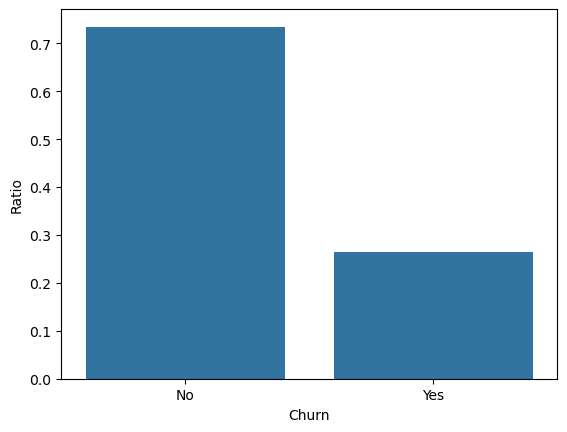

In [328]:
sns.barplot(data=churn_ratio, x='Churn', y='Ratio')

### 4.2. Числовые признаки и связь с оттоком  
Посмотрим, как ежемесячные платежи и срок сотрудничества (tenure) связаны с вероятностью ухода клиента.

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

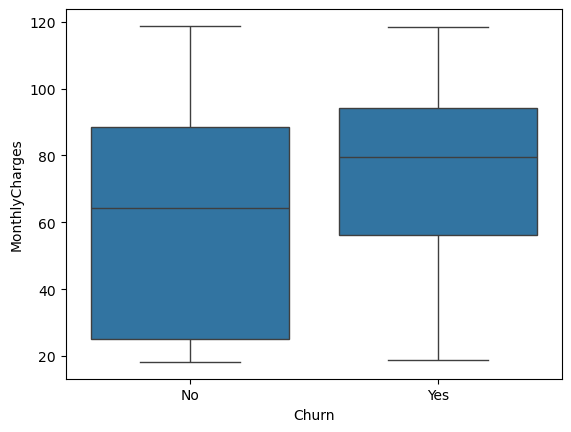

In [218]:
sns.boxplot(data=data, x=y.Churn, y=X.MonthlyCharges)

<Axes: xlabel='Churn', ylabel='tenure'>

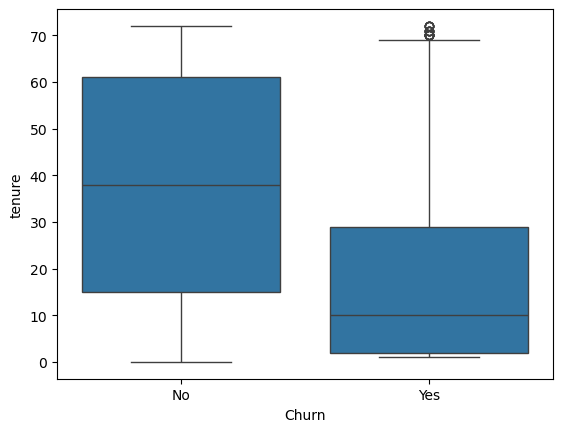

In [322]:
sns.boxplot(data=data, x=y.Churn, y=X.tenure)

### 4.3. Категориальные признаки  
Создадим функцию для визуализации категориальных переменных и посмотрим, какие из них могут быть связаны с оттоком.

In [314]:
#функция для визуализации распределения категориальных признаков
def cat_var_viz(df, col, normalize=False):
    if normalize:
        data = df[col].value_counts(normalize=True).reset_index()
        data.columns = [col, 'ratio']
        sns.barplot(data=data, x=col, y='ratio')
        plt.ylim(0,1)
        plt.ylabel('Доля')
    else:
        sns.countplot(data=df, x=col)
        plt.ylabel('Количество')

    plt.title(f'Pacпределение {col}')
    plt.xticks(rotation=10)
    plt.show()

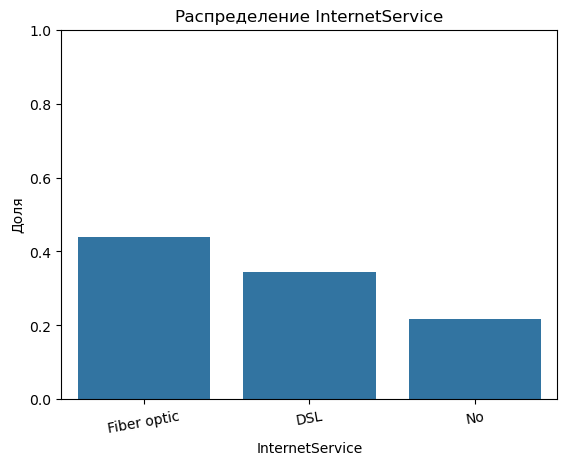

In [316]:
cat_var_viz(data, 'InternetService', normalize=1)

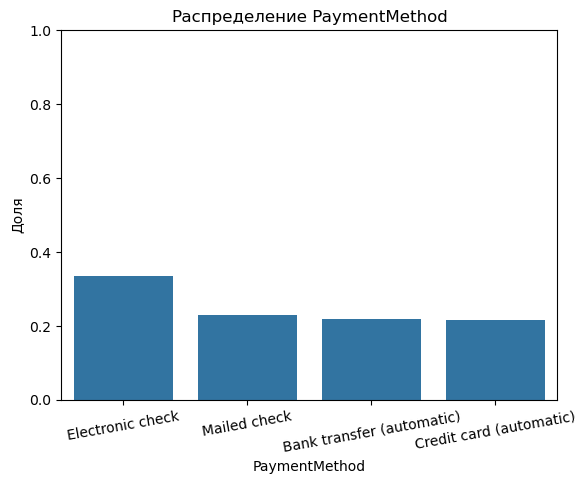

In [318]:
cat_var_viz(data, 'PaymentMethod', normalize=1)

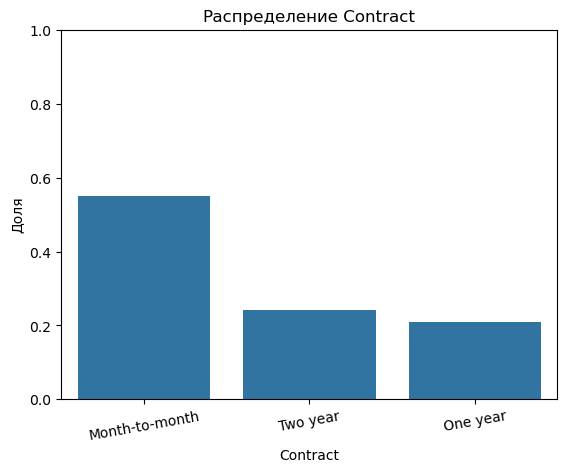

In [320]:
cat_var_viz(data, 'Contract', normalize=1)

## 5. Подготовка данных  
На этом этапе:
- очистим данные и приведём типы признаков к корректному виду,  
- закодируем категориальные переменные,  
- масштабируем числовые признаки,  
- разделим данные на обучающую и тестовую выборки.

In [403]:
#Масштабируем несколько ключевых числовых признаков: MonthlyCharge, tenure, TotalCharge
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['tenure', 'MonthlyCharges','TotalCharges']])
scaled_features_df = pd.DataFrame(scaled_features, columns=['tenure', 'MonthlyCharges', 'TotalCharges'])
scaled_data = data
scaled_data[['tenure', 'MonthlyCharges','TotalCharges']] = scaled_features_df[['tenure', 'MonthlyCharges','TotalCharges']]

scaled_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,-1.277445,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,-1.160323,-0.992611,No
1,5575-GNVDE,Male,0,No,No,0.066327,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,-0.259629,-0.172165,No
2,3668-QPYBK,Male,0,No,No,-1.236724,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,-0.362660,-0.958066,Yes
3,7795-CFOCW,Male,0,No,No,0.514251,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),-0.746535,-0.193672,No
4,9237-HQITU,Female,0,No,No,-1.236724,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,0.197365,-0.938874,Yes


In [574]:
x_scaled = scaled_data.drop('Churn', axis=1)

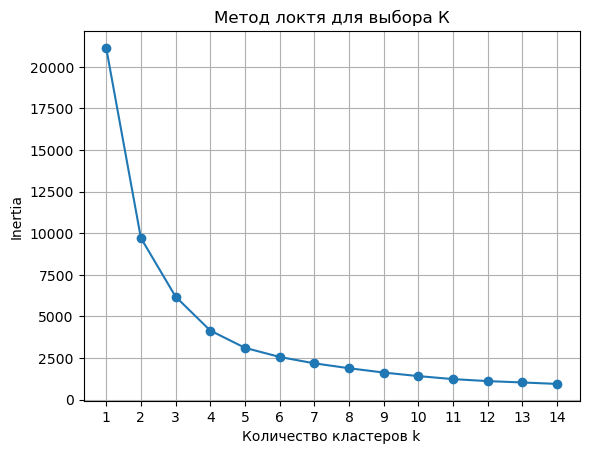

In [419]:
#Обучим k-means используя elbow method
inertias = []
K = range(1,15)

for k in K:
    kmeans = KMeans(n_clusters=k,init='random')
    kmeans.fit(scaled_features_df)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'o-')
plt.title('Метод локтя для выбора К')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid(True)
plt.show()

In [461]:
k5_means = KMeans(n_clusters=5, init='random')
k5_means.fit(scaled_features_df)

k5_means.labels_

array([1, 0, 1, ..., 1, 4, 3], dtype=int32)

In [463]:
data['cluster'] = k5_means.labels_

data.cluster

0       1
1       0
2       1
3       2
4       4
       ..
7038    4
7039    3
7040    1
7041    4
7042    3
Name: cluster, Length: 7043, dtype: int32

In [465]:
#Понизим размерность данных, применив рса с двумя собственными векторами
pca = PCA(n_components=2)
x_pca = pca.fit_transform(scaled_features_df)
x_pca

array([[-1.94844123, -0.08351071],
       [-0.20298846, -0.23543701],
       [-1.51483269,  0.52180474],
       ...,
       [-1.62859587, -0.34575081],
       [-1.07858557,  1.00828851],
       [ 2.77618449,  0.12248019]])

In [467]:
data['pc1'] = x_pca[:,0]
data['pc2'] = x_pca[:,1]
data[['pc1','pc2']].head()

,pc1,pc2
0,-1.948441,-0.083511
1,-0.202988,-0.235437
2,-1.514833,0.521805
3,-0.199743,-0.891781
4,-1.229988,0.964445


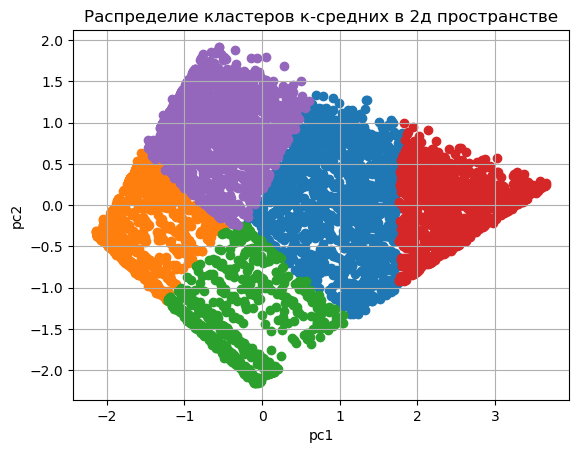

In [469]:
for cluster in sorted(data['cluster'].unique()):
    subset = data[data['cluster'] == cluster]
    plt.scatter(subset['pc1'], subset['pc2'])

plt.grid(True)
plt.title('Распределие кластеров к-средних в 2д пространстве')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

In [515]:
#быстрая проверка средних значений классов
cluster_summary = data.groupby('cluster', as_index=0).mean(numeric_only=True)
cluster_summary

,cluster,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,pc1,pc2
0,0,0.204480,0.571125,0.534014,0.603542,0.984757,0.039621
1,1,0.071903,-0.912044,-1.104268,-0.874749,-1.635546,-0.268038
2,2,0.070601,0.855933,-1.204706,-0.345629,-0.329546,-1.452883
3,3,0.220653,1.338291,1.138574,1.839092,2.535243,-0.022585
4,4,0.220083,-0.837444,0.489984,-0.594840,-0.632552,0.932957


In [958]:
# cluster_summary.rename(index={'0':'Возрастные клиенты с средними затратами',
#                           '1':'Молодые новые клиенты с низкими затратами',
#                            '2':'Молодые лояльные клиенты с низкими затратами',
#                            '3':'Возрастные лояльные клиенты с высокими затратами',
#                            '4':'Возрастные новые клиенты с средними затратами'}, inplace=True)

cluster_summary.index = ['Возрастные лояльные клиенты с средними затратами',
                          'Молодые новые клиенты с низкими затратами',
                           'Молодые лояльные клиенты с низкими затратами',
                           'Возрастные лояльные клиенты с высокими затратами',
                           'Возрастные новые клиенты с средними затратами']
cluster_summary

,cluster,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,pc1,pc2
Возрастные лояльные клиенты с средними затратами,0,0.204480,0.571125,0.534014,0.603542,0.984757,0.039621
Молодые новые клиенты с низкими затратами,1,0.071903,-0.912044,-1.104268,-0.874749,-1.635546,-0.268038
Молодые лояльные клиенты с низкими затратами,2,0.070601,0.855933,-1.204706,-0.345629,-0.329546,-1.452883
Возрастные лояльные клиенты с высокими затратами,3,0.220653,1.338291,1.138574,1.839092,2.535243,-0.022585
Возрастные новые клиенты с средними затратами,4,0.220083,-0.837444,0.489984,-0.594840,-0.632552,0.932957


In [578]:
print(y)
x_scaled.head()

     Churn
0       No
1       No
2      Yes
3       No
4      Yes
...    ...
7038    No
7039    No
7040    No
7041   Yes
7042    No

[7043 rows x 1 columns]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,cluster,pc1,pc2
0,7590-VHVEG,Female,0,Yes,No,-1.277445,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,-1.160323,-0.992611,1,-1.948441,-0.083511
1,5575-GNVDE,Male,0,No,No,0.066327,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,-0.259629,-0.172165,0,-0.202988,-0.235437
2,3668-QPYBK,Male,0,No,No,-1.236724,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,-0.362660,-0.958066,1,-1.514833,0.521805
3,7795-CFOCW,Male,0,No,No,0.514251,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),-0.746535,-0.193672,2,-0.199743,-0.891781
4,9237-HQITU,Female,0,No,No,-1.236724,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,0.197365,-0.938874,4,-1.229988,0.964445


In [1037]:
#One-hot encoding для категориальных переменных 
x_encoding = x_scaled 
cat_vars = ['gender', 'SeniorCitizen', 'Dependents', 'PhoneService', 'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
splitting_cat_vars = pd.get_dummies(x_encoding[cat_vars])

x_encoding = x_encoding.drop(cat_vars, axis=1)
x_encoding[splitting_cat_vars.columns] = splitting_cat_vars

#Yes -> 1, No -> 0, splitting dataset on train and test samples
y = pd.DataFrame(data['Churn'])
y = y['Churn'].map({'Yes':1, 'No':0})
x_encoding['Partner'] = x_encoding['Partner'].map({'Yes':1, 'No':0})
x_encoding = x_encoding.drop('customerID', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_encoding, y, test_size=0.3, stratify=y)

X_train = X_train.drop(['pc1', 'pc2'], axis=1)
X_test = X_test.drop(['pc1', 'pc2'], axis=1)

## 6. Моделирование  
Обучим несколько моделей машинного обучения и проанализируем их метрики качества для предсказания оттока клиентов и проанализируем их метрики качества.  
Начнём с простой линейной модели — логистической регрессии, а затем попробуем более сложную — случайный лес.

In [1040]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred_logregr = model.predict(X_test)

In [1042]:
print('Accuracy: ', accuracy_score(y_test, y_pred_logregr))
print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred_logregr))
print('\nClassification Report:\n', classification_report(y_test, y_pred_logregr))


Accuracy:  0.8012304779933743

Confusion matrix:
 [[1394  158]
 [ 262  299]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1552
           1       0.65      0.53      0.59       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



In [1044]:
pd.Series(y_pred).value_counts()

0    1650
1     463
Name: count, dtype: int64

<Axes: >

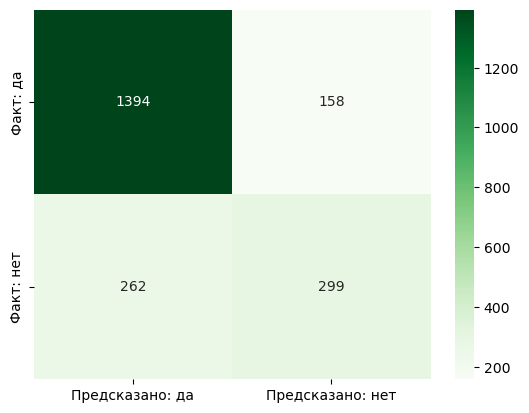

In [1046]:
sns.heatmap(confusion_matrix(y_test, y_pred_logregr), annot=True, fmt='d', cmap='Greens',
           xticklabels=['Предсказано: да', 'Предсказано: нет'],
            yticklabels=['Факт: да', 'Факт: нет'])

In [1048]:
#Обучим рандомфорест и сравним метрики с логистической регрессией
clf = RandomForestClassifier(random_state=42)

params = {'n_estimators':range(10, 90, 8),
             'max_depth': range(1, 50, 5),
             'min_samples_leaf': range(1, 20, 2),
             'min_samples_split': range(2,10)}

#scoring=recall, поскольку в исследуемом датасете важнее удержать клиента, который скорее всего уйдет
grid_search_clf = GridSearchCV(clf, params, scoring='recall', cv=5, n_jobs=-1)
grid_search_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 50, 5),
                         'min_samples_leaf': range(1, 20, 2),
                         'min_samples_split': range(2, 10),
                         'n_estimators': range(10, 90, 8)},
             scoring='recall')

In [1052]:
grid_search_clf.best_params_

{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 18}

In [1054]:
best_clf = grid_search_clf.best_estimator_

In [1056]:
y_pred_rforest = pd.DataFrame(best_clf.predict(X_test))

In [1058]:
print('Accuracy: ', accuracy_score(y_test, y_pred_rforest))
print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred_rforest))
print('\nClassification Report:\n', classification_report(y_test, y_pred_rforest))

Accuracy:  0.7898722195929957

Confusion matrix:
 [[1400  152]
 [ 292  269]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1552
           1       0.64      0.48      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



<Axes: >

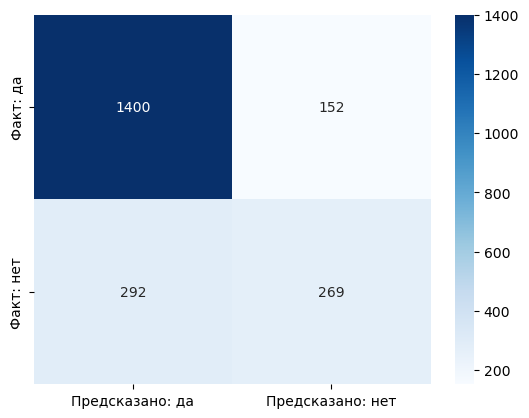

In [1060]:
sns.heatmap(confusion_matrix(y_test, y_pred_rforest), annot=True, fmt='d', cmap='Blues',
           xticklabels=['Предсказано: да', 'Предсказано: нет'],
            yticklabels=['Факт: да', 'Факт: нет'])

## 7. Интерпретация результатов  
Посмотрим, какие признаки оказывают наибольшее влияние на решение модели.  
Это поможет понять, почему клиенты уходят, и что можно сделать для их удержания.

In [1063]:
feature_importances = pd.DataFrame({
                        'feature': X_train.columns,
                        'importances': best_clf.feature_importances_
})
feature_importances = feature_importances.sort_values('importances', ascending=False)
feature_importances.head()

,feature,importances
1,tenure,0.134830
3,TotalCharges,0.119385
2,MonthlyCharges,0.088031
36,Contract_Month-to-month,0.062803
4,cluster,0.061309


Text(0, 0.5, 'Name of feature')

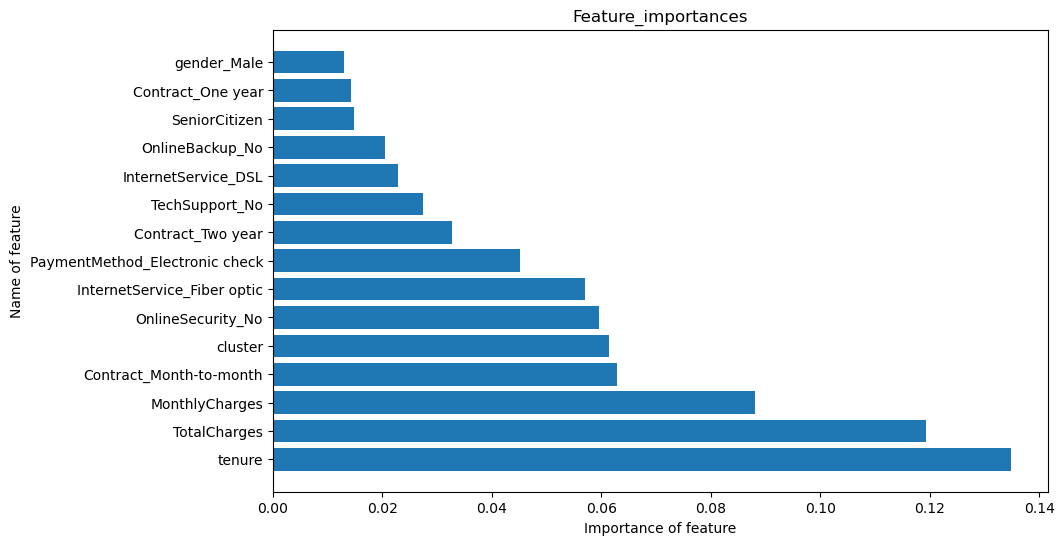

In [1065]:
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'][:15],
         feature_importances['importances'][:15])
plt.title('Feature_importances')
plt.xlabel('Importance of feature')
plt.ylabel('Name of feature')

In [1067]:
y_pred_rforest_ytrain = pd.DataFrame(best_clf.predict(X_train))
accuracy_score(y_train, y_pred_rforest_ytrain)

0.8768762677484787

In [1069]:
predicted_churn = pd.concat([y_pred_rforest_ytrain, y_pred_rforest])
predicted_churn.index = [i for i in range(data.shape[0])]
predicted_churn

,0
0,1
1,0
2,0
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


In [1071]:
data['Predicted_Churn'] = predicted_churn
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster,pc1,pc2,Predicted_Churn
0,7590-VHVEG,Female,0,Yes,No,-1.277445,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,-1.160323,-0.992611,No,1,-1.948441,-0.083511,1
1,5575-GNVDE,Male,0,No,No,0.066327,Yes,No,DSL,Yes,...,One year,No,Mailed check,-0.259629,-0.172165,No,0,-0.202988,-0.235437,0
2,3668-QPYBK,Male,0,No,No,-1.236724,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,-0.362660,-0.958066,Yes,1,-1.514833,0.521805,0
3,7795-CFOCW,Male,0,No,No,0.514251,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),-0.746535,-0.193672,No,2,-0.199743,-0.891781,0
4,9237-HQITU,Female,0,No,No,-1.236724,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,0.197365,-0.938874,Yes,4,-1.229988,0.964445,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,-0.340876,Yes,Yes,DSL,Yes,...,One year,Yes,Mailed check,0.665992,-0.127605,No,4,0.045340,0.742463,0
7039,2234-XADUH,Female,0,Yes,Yes,1.613701,Yes,Yes,Fiber optic,No,...,One year,Yes,Credit card (automatic),1.277533,2.242606,No,3,3.027302,-0.104335,0
7040,4801-JZAZL,Female,0,Yes,Yes,-0.870241,No,No phone service,DSL,Yes,...,Month-to-month,Yes,Electronic check,-1.168632,-0.852932,No,1,-1.628596,-0.345751,0
7041,8361-LTMKD,Male,1,Yes,No,-1.155283,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Mailed check,0.320338,-0.870513,Yes,4,-1.078586,1.008289,1


In [1073]:
#В каких кластерах самая высокая концентрация клиентов, которых модель предсказывает как уходящих?
cluster_analysis = data[['cluster', 'Predicted_Churn']]
cluster_stats = cluster_analysis.groupby('cluster', as_index=0)\
                                    .agg({
                                            'Predicted_Churn': [
                                                ('churn_rate', 'mean'),           
                                                ('total_customers', 'count'),    
                                                ('churn_count', 'sum')
                                                ]
                                        })\
                                        .round(3)
cluster_stats.index = cluster_summary.index

cluster_stats

cluster Predicted_Churn  \
                                                              churn_rate   
Возрастные лояльные клиенты с средними затратами       0           0.214   
Молодые новые клиенты с низкими затратами              1           0.221   
Молодые лояльные клиенты с низкими затратами           2           0.226   
Возрастные лояльные клиенты с высокими затратами       3           0.217   
Возрастные новые клиенты с средними затратами          4           0.207   

                                                                              
                                                 total_customers churn_count  
Возрастные лояльные клиенты с средними затратами            1384         296  
Молодые новые клиенты с низкими затратами                   1655         365  
Молодые лояльные клиенты с низкими затратами                 949         214  
Возрастные лояльные клиенты с высокими затратами            1133         246  
Возрастные новые клиенты с средними затратами               1922         397

In [1075]:
print(*cluster_summary.index[2:4], sep='\n')

Молодые лояльные клиенты с низкими затратами
Возрастные лояльные клиенты с высокими затратами


### Есть ли кластеры, где модель почти не предсказывает отток?
На этот вопрос можно ответить сразу, исходя из данных в таблице cluster_stats: таких кластеров скорее нет, потому что самая низкая доля уходящих по кластерам - 0.207, самая высокая - 0,226

## 8. Выводы и рекомендации  


Глубокая сегментация клиентской базы выявила три критических узла оттока, требующих точечного вмешательства. При кажущейся однородности уровня оттока `(21-22.6%)` мы имеем дело с принципиально разными драйверами ухода в каждом сегменте, что делает `унифицированную стратегию удержания неэффективной`.

**Кластер 4: Коррекция процесса онбординга для возрастных клиентов**
Сегмент демонстрирует наибольшую абсолютную потерю - `397` клиентов, при этом сочетание низкого `tenure (-0.84)` и средних `MonthlyCharges (0.49)` указывает на сбой в процессе адаптации. Отраслевая практика показывает, что такие клиенты часто не доходят до "точки привыкания" к сервису.
* Внедрить `постепенно возрастающий кэшбэк` с привязкой к прохождению 3-х месячного рубежа
* Активировать `автоматические офферы` на дополнительные услуги после третьего успешного платежа
* Назначить персональных консультантов для клиентов с потенциалом `LTV выше 75-го перцентиля`

**Кластер 3: Пересмотр программ лояльности для премиум-аудитории**
Парадокс сегмента с максимальными `tenure (1.34`) и `MonthlyCharges (1.14)` при наивысшем `проценте оттока (22.6%)` свидетельствует о ценовой усталости. Гипотеза: существующие механики удержания не соответствуют ожиданиям зрелых клиентов.
* Разработать `многоуровневую программу лояльности` с приоритетным обслуживанием и эксклюзивными опциями
* Запустить `систему превентивного отслеживания` удовлетворенности с реакцией в течение 2 часов
* Протестировать `гибкие ценовые конфигурации с сохранением текущего ARPU`

**Кластер 1: Стратегия управляемой монетизации**
Что показательно, сегмент с минимальными `MonthlyCharges (-1.10)` демонстрирует относительно низкий отток, однако `их LTV не покрывает CAC`. В противовес классическому удержанию, предлагаем фокус на повышении ценности клиента.
* Запустить `точечные кампании апселла` через каналы с минимальной стоимостью взаимодействия
* Внедрить `модульную систему тарифов` с возможностью временного понижения нагрузки
* Переориентировать `KPI коммерческого блока с вала привлечения на маржинальность первого года`
